In [1]:
import pandas as pd
import matplotlib.pylab as plt
import surprise
import numpy as np
from surprise import Reader
from surprise import Dataset

In [2]:
# Read csv
trade_df = pd.read_csv("./data/smart_ulocal_2019.csv", encoding="utf-8", parse_dates=['ISSUEDT'],
                       dtype={'HSCD': str, 'BYRPRTNUM': str, 'SPLYPRTNUM': str})
len(trade_df)

651471

In [44]:
trade_df.head()

,BYRPRTNUM,SPLYPRTNUM,HSCD,ISSUEDT
0,1018109147,1018116406,8512201090,2019-01-07
1,1018109147,1018116406,8512201090,2019-01-07
2,1018109147,1018116406,8512201090,2019-01-07
3,1018109147,1018116406,8512201090,2019-01-07
4,1018109147,1018116406,8512201090,2019-01-07


In [3]:
trade_df.HSCD = trade_df.HSCD.str.slice(stop=6)

In [12]:
hscd_list = trade_df.groupby('HSCD').agg('size').sort_values(ascending=False).head().index.tolist()
hscd_list

['870899', '870829', '330499', '720851', '392690']

In [13]:
df = trade_df.loc[trade_df.HSCD.isin(hscd_list)]

In [15]:
df = df[['SPLYPRTNUM', 'BYRPRTNUM']]

In [18]:
df = df.groupby(['SPLYPRTNUM', 'BYRPRTNUM']).agg('size').reset_index()

In [32]:
df.columns = ['spl', 'byr', 'trd_cnt']

In [20]:
df.head()

,sql,byr,trd_cnt
0,1010289001,2198115334,2
1,1011123108,1368107674,9
2,1018116406,1018109147,2680
3,1018116406,1068197118,255
4,1018116406,1198102316,4326


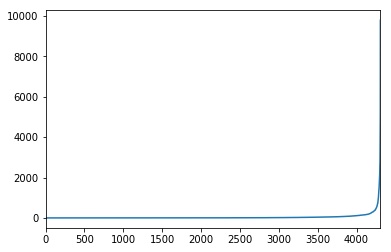

In [21]:
df.sort_values('trd_cnt').trd_cnt.reset_index(drop=True).plot()

In [28]:
df.groupby('trd_cnt').agg('size').sum()

4308

In [29]:
df.groupby('trd_cnt').agg('size')

trd_cnt
1       1053
2        537
3        271
4        233
5        158
6        120
7        103
8         91
9         78
10        80
11        72
12        53
13        44
14        36
15        43
16        51
17        33
18        26
19        42
20        35
21        26
22        23
23        22
24        24
25        16
26        24
27        25
28        14
29        20
30        19
        ... 
909        1
927        1
945        1
968        1
1037       1
1074       1
1212       1
1258       1
1318       1
1365       1
1370       1
1438       1
1442       1
1520       1
1609       1
1749       1
1782       1
1858       1
1909       1
2009       1
2127       1
2256       1
2579       1
2680       1
2719       1
3353       1
4213       1
4326       1
5152       1
9780       1
Length: 312, dtype: int64

In [33]:
b = df['byr'].value_counts() >= 5
b = b[b].index.tolist()

In [34]:
s = df['spl'].value_counts() >= 5
s = s[s].index.tolist()

In [35]:
df = df.loc[(df['byr'].isin(b)) & (df['spl'].isin(s))].reset_index(drop=True)

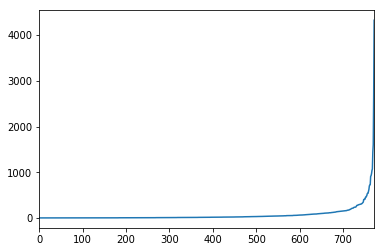

In [37]:
df.sort_values('trd_cnt').trd_cnt.reset_index(drop=True).plot()

In [38]:
df.groupby('trd_cnt').agg('size').sum()

773

In [39]:
df.groupby('trd_cnt').agg('size')

trd_cnt
1       86
2       55
3       41
4       41
5       27
6       18
7       14
8       18
9       17
10      13
11      17
12      18
13       9
14       9
15      11
16      13
17      11
18       4
19      11
20       9
21       8
22       6
23       5
24       9
25       2
26       3
27       7
28       4
29       8
30       1
        ..
303      2
312      1
315      1
325      1
333      1
348      1
403      1
404      1
412      2
451      1
452      1
476      1
483      1
527      1
540      1
541      1
582      1
625      1
701      1
722      1
727      1
909      1
927      1
968      1
1037     1
1074     1
1438     1
1609     1
2680     1
4326     1
Length: 187, dtype: int64

In [94]:
df.groupby('trd_cnt').agg('size').loc[401:].sum()

25

In [95]:
import sys
rating = {1:[1,2], 2:[3,6], 3:[7,12], 4:[13,20], 5:[21,33],
          6:[34,51], 7:[52,85], 8:[86,145], 9:[146,400], 10:[401,sys.maxsize]}

In [96]:
for i in rating:
    df.loc[(df.trd_cnt >= rating[i][0]) & (df.trd_cnt <= rating[i][1]), 'trd_cnt'] = i    

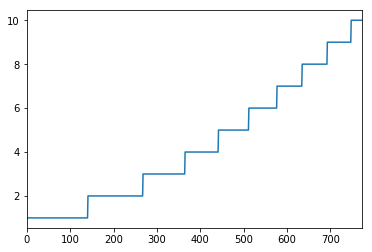

In [97]:
df.sort_values('trd_cnt').trd_cnt.reset_index(drop=True).plot()

In [98]:
df.head()

,spl,byr,trd_cnt
0,1018116406,1018109147,10
1,1018116406,1068197118,9
2,1018116406,1198102316,10
3,1018116406,6098101770,6
4,1028133223,1408171331,2


In [99]:
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(df, reader)

In [100]:
from surprise.model_selection import cross_validate
bsl_options = {
    'method': 'als',
    'n_epochs': 5,
    'reg_u': 12,
    'reg_i': 5
}
algo = surprise.BaselineOnly(bsl_options)
cross_validate(algo, data)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'fit_time': (0.0015892982482910156,
  0.0015997886657714844,
  0.0011794567108154297,
  0.0012555122375488281,
  0.0008797645568847656),
 'test_mae': array([2.15817734, 1.88460085, 1.94740594, 1.82044816, 2.02520091]),
 'test_rmse': array([2.50580815, 2.2639429 , 2.28322532, 2.17481284, 2.34877702]),
 'test_time': (0.001669168472290039,
  0.001745462417602539,
  0.0009324550628662109,
  0.0007445812225341797,
  0.0006270408630371094)}

In [101]:
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise import SVDpp
from surprise import SlopeOne
from surprise import NMF
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,fit_time,test_rmse,test_time
Algorithm,,,
KNNBaseline,0.001308,2.203034,0.021594
KNNBasic,0.000636,2.263644,0.015416
SVDpp,0.053054,2.275293,0.003278
SVD,0.020916,2.299630,0.001420
SlopeOne,0.001419,2.333353,0.001654
NMF,0.031979,2.338597,0.001150
BaselineOnly,0.000689,2.403459,0.000944
CoClustering,0.018862,2.462305,0.001037
KNNWithZScore,0.005629,2.507647,0.019785


In [103]:
%%time
algo = surprise.SVD(n_factors=100)
cross_validate(algo, data)["test_mae"].mean()

CPU times: user 125 ms, sys: 2.59 ms, total: 128 ms
Wall time: 127 ms


1.8543665599910892

In [104]:
from surprise.model_selection import train_test_split
from surprise import accuracy
trainset, testset = train_test_split(data, test_size=0.25)
algo = surprise.SVD(n_factors=100)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 2.3350


2.3350304433526503

In [105]:
def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

rcm_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
rcm_df['Iu'] = rcm_df.uid.apply(get_Iu)
rcm_df['Ui'] = rcm_df.iid.apply(get_Ui)
rcm_df['err'] = abs(rcm_df.est - rcm_df.rui)

In [106]:
rcm_df.sort_values(by='err').head(10)

,uid,iid,rui,est,details,Iu,Ui,err
54,1248132675,5058102351,4.0,3.965616,{'was_impossible': False},4,1,0.034384
31,1348105307,1068197118,2.0,2.069074,{'was_impossible': False},4,94,0.069074
78,1078732411,1018109147,6.0,6.088929,{'was_impossible': False},3,95,0.088929
1,1398118239,1018109147,7.0,7.106225,{'was_impossible': False},3,95,0.106225
185,6228103825,1198102316,4.0,3.810057,{'was_impossible': False},3,94,0.189943
84,1398101043,1228174534,3.0,3.237012,{'was_impossible': False},4,57,0.237012
45,5148105798,1068197118,3.0,3.269022,{'was_impossible': False},4,94,0.269022
142,2103668377,7328800084,4.0,4.279525,{'was_impossible': False},1,0,0.279525
85,3128509274,1198102316,6.0,5.716166,{'was_impossible': False},3,94,0.283834
72,2248520894,1228174534,3.0,3.286175,{'was_impossible': False},3,57,0.286175


In [107]:
rcm_df.sort_values(by='err').tail(10)

,uid,iid,rui,est,details,Iu,Ui,err
134,1248118241,1018116406,1.0,5.612433,{'was_impossible': False},4,73,4.612433
155,6208101350,1018116406,1.0,5.640014,{'was_impossible': False},2,73,4.640014
178,1308163343,1068197118,2.0,6.640360,{'was_impossible': False},7,94,4.640360
154,1078614075,1018116406,9.0,4.268293,{'was_impossible': False},3,73,4.731707
90,3018128633,1018116406,9.0,4.162037,{'was_impossible': False},2,73,4.837963
135,3018123415,1018116406,10.0,5.161584,{'was_impossible': False},2,73,4.838416
115,1348102576,1018116406,1.0,5.861042,{'was_impossible': False},5,73,4.861042
39,3068124501,1018116406,10.0,4.964850,{'was_impossible': False},3,73,5.035150
148,6098101877,1018116406,10.0,4.910639,{'was_impossible': False},4,73,5.089361
34,1398100699,1258114248,9.0,3.822340,{'was_impossible': False},5,11,5.177660


<IPython.core.display.Javascript object>


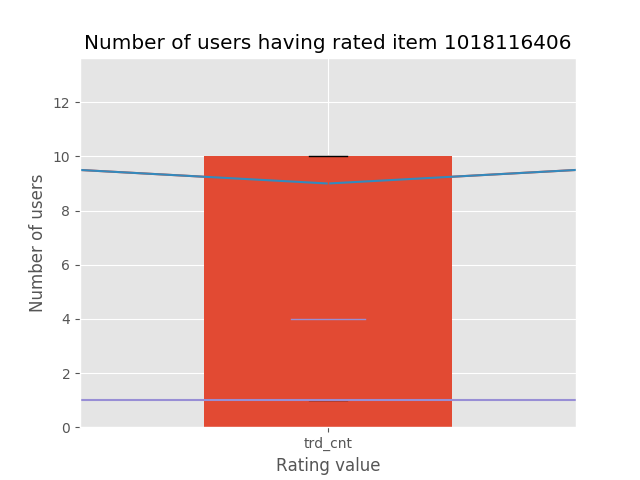

Text(0.5, 1.0, 'Number of users having rated item 1018116406')

In [108]:
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
matplotlib.style.use('ggplot')

counter = Counter([r for (_, r) in trainset.ir[trainset.to_inner_iid('1018116406')]])
pd.DataFrame.from_dict(counter, orient='index').plot(kind='bar', legend=False)
plt.xlabel('Rating value')
plt.ylabel('Number of users')
plt.title('Number of users having rated item 1018116406')